# Hello world

This Hello world example creates a simple quantum program and runs it on a quantum system. Begin with following the [Install and set up](install) instructions if you haven't already, including the steps to [Set up to use IBM Quantum&trade; Platform](setup-channel#set-up-to-use-ibm-quantum-platform).

We recommend that you use the [Jupyter](https://jupyter.org/install) development environment to interact with quantum computers. Be sure to install the recommended extra visualization support (`pip install qiskit[visualization]`), and note that zsh users need to put `'qiskit[visualization]'` in single quotes.

To learn about quantum computing in general, check out the [Basics of quantum information course](https://learning.quantum.ibm.com/course/basics-of-quantum-information) in IBM Quantum Learning.

The four steps to writing a quantum program are

1.  Map the problem to a quantum-native format

2.  Optimize the circuits and operators

3.  Execute using a quantum primitive function

4.  Analyze the results

## Step 1. Map the problem to a quantum-native format

In a quantum program, *quantum circuits* are the native format in which to represent quantum instructions, and *operators* represent the observables to be measured. When creating a circuit, you'll usually create a new [`QuantumCircuit`](/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit) object, then add instructions to it in sequence.

The following code cell creates a circuit that produces a *Bell state,* which is a specific two-qubit entangled state.

<Admonition type="note" title="Note: bit ordering">
  The Qiskit SDK uses the LSb 0 bit numbering where the $n^{th}$ digit has value $1 \ll n$ or $2^n$. Because we usually write numbers on paper with the most significant digits to the left and the least significant digits to the right (in the Hindu-Arabic system used in most of the world), this has the consequence that the bits are labeled with indices increasing <b>from right to left</b>. This LSb 0 convention makes mathematics easier and is the most commonly used for modern digital electronics, although the opposite convention MSb 0 is also found in some domains. Converting the $i^{th}$ index between LSb 0 and MSb 0 conventions on an $n$-bit register is as simple as $i \rightarrow n-i-1$. This differs across authors and software packages, so be aware! For more details, see the [Bit-ordering in the Qiskit SDK](../build/bit-ordering) topic.
</Admonition>

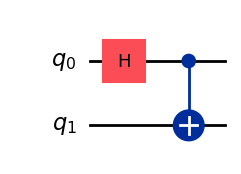

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

# Create a new circuit with two qubits
qc = QuantumCircuit(2)

# Add a Hadamard gate to qubit 0
qc.h(0)

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

See [`QuantumCircuit`](/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit) in the documentation for all available operations.

The following code cell uses the `quantum_info` package to create six two-qubit Pauli operators. The ZZ operator means Z on qubit 0 and Z on qubit 1. If the state is entangled, then the correlation between qubit 0 and qubit 1 is one.

In [3]:
# Set up six different observables.
observables_labels = ["ZZ", "ZI", "IZ", "XX", "XI"]
observables = [SparsePauliOp(label) for label in observables_labels]

<Admonition type="note" title="Important">
  To ensure faster and more efficient results, as of 1 March 2024, circuits and observables need to be transformed to only use instructions supported by the system (referred to as *instruction set architecture (ISA)* circuits and observables) before being submitted to the Qiskit Runtime primitives.  See the [transpilation documentation](../transpile) for instructions to transform circuits.  Due to this change, the primitives will no longer perform layout or routing operations.  Consequently, transpilation options referring to those tasks will no longer have any effect. By default, all primitives except Sampler V2 still optimize the input circuits. To bypass all optimization, set `optimization_level=0`.

*Exception*: When you initialize the Qiskit Runtime Service with the Q-CTRL channel strategy (example below), abstract circuits are still supported.

> ``` python
> service = QiskitRuntimeService(channel="ibm_cloud", channel_strategy="q-ctrl")
> ```
>
</Admonition>

## Step 2. Optimize the circuits and operators

Even though the circuit and operators for this example are quite simple, we still need to convert its instructions into those of a backend device's [Instruction Set Architecture (ISA)](../transpile/#instruction-set-architecture).  This ensures the circuit complies with the constraints of a device (namely its native basis gates and qubit connectivity).

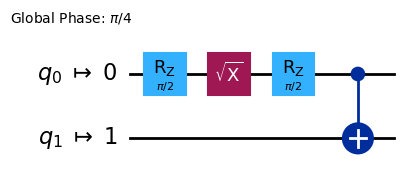

In [5]:
# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService()

# Use the following code instead if you want to run on a simulator:
# from qiskit_ibm_runtime.fake_provider import FakeCairoV2
# backend = FakeCairoV2()

# Run on the least-busy backend you have access to
backend = service.least_busy(simulator=False, operational=True)

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw('mpl', idle_wires=False)

## Step 3. Execute using a quantum primitive function

Quantum computers can produce random results, so you'll often want to collect a sample of the outputs by running the circuit many times. You can estimate the value of the observable using the `Estimator` class. `Estimator` is one of our two [primitives](../run/primitives-get-started); the other is `Sampler`, which can be used to get data from a quantum computer.  These objects possess a `run()` method which will execute the selection of circuits, observables, and parameters (if applicable) using what's known as a [primitive unified bloc (PUB)](../run/primitives#sampler-v2).

In [3]:
# Construct the Estimator instance we want to use.

estimator = Estimator(backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, observables)])

# This is the result of the entire submission.  We submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]

qiskit_runtime_service.__init__:INFO:2024-03-11 20:15:06,834: Default instance: ibm-q-internal/deployed/default
base_primitive._run:INFO:2024-03-11 20:15:30,536: Submitting job using options {'options': {'default_shots': 5000}, 'version': 2, 'support_qiskit': True, 'resilience_level': 1}
qiskit_runtime_service.run:INFO:2024-03-11 20:15:30,537: Instance selected: ibm-q-internal/live-data/live-data-demo


## Step 4. Analyze the results

<admonition type="note">
  You might need to run `pip install matplotlib` if you do not already have it installed.
</admonition>

The `values` property is a list of expectation values for each of the observables we provided.

<ErrorbarContainer object of 3 artists>

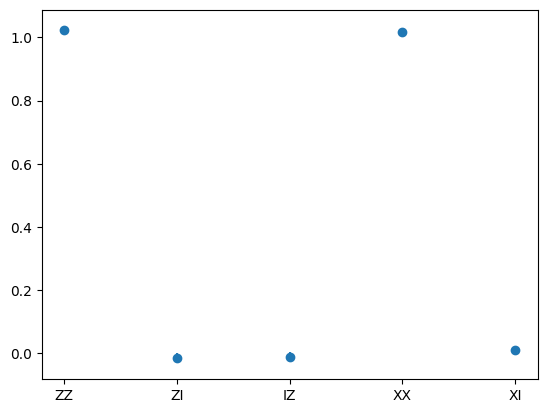

In [4]:
# Plot the result

from matplotlib import pyplot as plt

data = observables_labels
values = pub_result.data.evs

errors = pub_result.data.ensemble_standard_error

plt.errorbar(observables_labels, values, yerr=errors, fmt="o")

Here we see that for qubits 0 and 1, the independent values of both X and Z are 0, while the correlations are 1. This is a hallmark of quantum entanglement.

## Next steps

<Admonition type="tip" title="Recommendations">
  *   Learn how to [build circuits](../build/) in more detail.

  *   Try one of the [workflow example tutorials.](https://learning.quantum.ibm.com/catalog/tutorials?category=workflow-example)
</Admonition>